<a href="https://colab.research.google.com/github/EtienneNoir/BitsHardware/blob/main/OneShotLearingSiamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import shutil

etiennebanza_newdataset_path = kagglehub.dataset_download('etiennebanza/newdataset')
etiennebanza_faceforverification_path = kagglehub.dataset_download('etiennebanza/faceforverification')
etiennebanza_finaldatasetforthis_path = kagglehub.dataset_download('etiennebanza/finaldatasetforthis')
etiennebanza_etienne_path = kagglehub.dataset_download('etiennebanza/etienne')
etiennebanza_finalfinaldataset_path = kagglehub.dataset_download('etiennebanza/finalfinaldataset')
etiennebanza_clearrefernce_path = kagglehub.dataset_download('etiennebanza/clearrefernce')
etiennebanza_farfaces_path = kagglehub.dataset_download('etiennebanza/farfaces')

print('Data source import complete.')


<a href="https://colab.research.google.com/github/EtienneNoir/OneShot/blob/main/Main__One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment without transfer learning

In [ ]:
pip install keras-facenet

Note: you may need to restart the kernel to use updated packages.


### With Transfer learning

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.datasets import fetch_lfw_people

from tensorflow.keras import Model, Input, layers

from tensorflow.keras.optimizers import Adam

from keras_facenet import FaceNet

In [ ]:
def load_lfw_data(min_faces=5, resize=0.5):

    """Fetching the people from the main dataset that have 5 or more variations or different images of themselves"""

    # Retrieving the LFW dataset and returning the images (x) and their corresponding target images (y)

    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces, resize=resize)



    return lfw_people.images, lfw_people.target, lfw_people.images.shape[1:]

Number of samples: 5985
Number of people with 5 or more images: 423


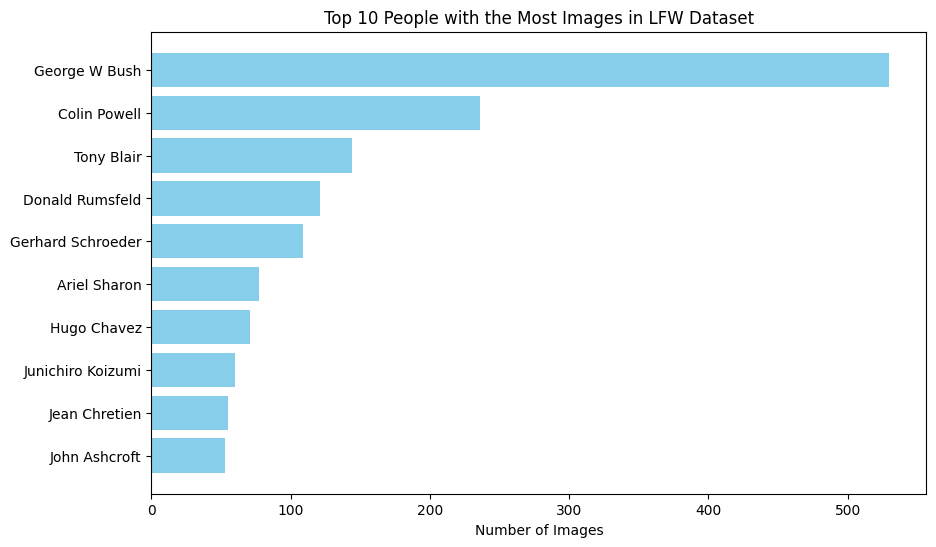

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=5, resize=0.5)



numberOfImages = lfw_people.data.shape[0] # retrieving the sum of all the images in the dataset

targetNames = lfw_people.target_names # retrieving the names of the actual images, to see which individual has teh most variations

targets = lfw_people.target #



# Counting how many images each person has in the dataset

unique, counts = np.unique(targets, return_counts=True)



# Sorting by number of images per person in descending order

sortedIndex = np.argsort(counts)[::-1]  # Sort in descending order

sortedNames = targetNames[sortedIndex]

sortedCounts = counts[sortedIndex]



# Printing the number of people/ images

print(f'Number of samples: {numberOfImages}')

print(f'Number of people with 5 or more images: {len(targetNames)}') # Now printing the unique people that have more than 5 images in teh returned dataset



# Plotting the top n people with the most images

top_n = 10  # Adjust the number of people to display

plt.figure(figsize=(10, 6))

plt.barh(sortedNames[:top_n][::-1], sortedCounts[:top_n][::-1], color='skyblue')

plt.xlabel('Number of Images')

plt.title(f'Top {top_n} People with the Most Images in LFW Dataset')

plt.show()



The frequency graph shows that George W. Bush has a lot more images than other people in the dataset. This means the model will get more chances to learn the features of his face, which can make it really good at recognizing him. However, this can cause the model to become biased, focusing too much on George and struggling to recognize others who don’t have as many images. By using fetch_lfw_people(min_faces_per_person=5, resize=0.5), we can help solve this by only including people who have at least five images. This creates a more balanced dataset, giving the model a fairer chance to learn about different people.



Additionally, using transfer learning with FaceNet, where we freeze the embedding model (by setting embedding_model.trainable = False), means we start with a model that has already learned to recognize general facial features from a large dataset. This prevents the model from focusing too much on George’s features, even if he has more images, and instead helps it generalize better to recognize all faces more equally. Together, these strategies help the model avoid bias and perform better on different people.

In [ ]:
def get_triplets(X, y): # X represents the input dataset, which is an array of images, y represents the label that identifies which person the image corresponds to

    """Generating the anchor, positive, and negative image triplets."""

    triplets = [] # Initializing an empty list that will store the generated triplets


    ''' A for loop that iterates over each image in the dataset X '''

    for i in range(len(X)):

        anchor = X[i] # Anchor image selected from the dataset at index i, this will be the reference image for creating the triplet

        positiveIndex = np.where(y == y[i])[0] # retrieving all the index number of the images (label) that corresponds to the anchor

        negativeIndex = np.where(y != y[i])[0] # retrieving all the index number of the images (label) that does not correspond to the anchor



        if len(positiveIndex) > 1: # This condition ensures that there is more than one image of the same person (positive) in the dataset

            positive = X[np.random.choice(positiveIndex)] # Selecting a random index from the positiveIndex and picks a positive example

            negative = X[np.random.choice(negativeIndex)] # Selecting a random index from the NegativeIndex and picks a negative example

            triplets.append((anchor, positive, negative)) # Appending the create pairs into the triplets dictionary


    return triplets



In [ ]:
def create_datasets_from_triplets(triplets, target_shape):

    """

    - This function takes a list of triplets (anchor, positive, negative images)

    and converts them into TensorFlow datasets that can be used for training.



    This function returns the following :

    - anchorDataset: TensorFlow dataset containing the anchor images.

    - positiveDataset: TensorFlow dataset containing the positive images (same class as anchor).

    - negativeDataset: TensorFlow dataset containing the negative images (different class from anchor).


    """

    anchorImages = [triplet[0] for triplet in triplets]

    positiveImages = [triplet[1] for triplet in triplets]

    negativeImages = [triplet[2] for triplet in triplets]



    anchorDataset = tf.data.Dataset.from_tensor_slices(anchorImages)

    positiveDataset = tf.data.Dataset.from_tensor_slices(positiveImages)

    negativeDataset = tf.data.Dataset.from_tensor_slices(negativeImages)



    return anchorDataset, positiveDataset, negativeDataset

In [ ]:
def preprocess_image(image, target_shape):

    """
    This function preprocess the input image by resizing and converting it from a grayscale image to RGB.

    """

    image = tf.expand_dims(image, axis=-1)  # Adding a channel dimension to make the image 3 dimensional since FaceNet are typically trained on RGB images and since pre-trained model is being used

    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, target_shape) # resizing the image to the desired shape, thus target height and target width



    # Converting grayscale to RGB by duplicating the single channel 3 times

    image = tf.image.grayscale_to_rgb(image)



    return image

In [ ]:
def preprocess_triplets(anchor, positive, negative, target_shape):

    """

    Preprocess triplet data.

    This function ensures that all three images in a triplet (anchor, positive, and negative) are preprocessed in the same way.

    It resizes the images to a uniform size (the target shape) and converts them to RGB, so they can be used by models like FaceNet.

    """

    return (

        preprocess_image(anchor, target_shape),

        preprocess_image(positive, target_shape),

        preprocess_image(negative, target_shape),

    )

In [ ]:
def triplet_loss(alpha=0.2, emb_dim=512): # emb_dim is the embedding dimension of the feature vectors generated by the FaceNet model

    """

    This function defines a triplet loss function that helps the model differentiate between similar and dissimilar faces by learning distances between embeddings.

    Credit goes to: https://github.com/13muskanp/Siamese-Network-with-Triplet-Loss

    Alpha is the distance threshold. It controls how much farther the negative sample should be from the anchor compared to the positive sample.

    """

    def loss(y_true, y_pred):

        anc = y_pred[:, :emb_dim] # Extracting the anchor embedding from the first part of the y_pred

        pos = y_pred[:, emb_dim:2*emb_dim] # Extracting the positive embedding (same person as the anchor).

        neg = y_pred[:, 2*emb_dim:] # Extracting the negative embedding (different person than the anchor).



        posDistance = tf.reduce_sum(tf.square(anc - pos), axis=1) # Calculating the squared difference between the anchor and positive embeddings.

        negDistance = tf.reduce_sum(tf.square(anc - neg), axis=1) # Calculating the squared difference between the anchor and negative embeddings.



        basicLoss = posDistance - negDistance + alpha # calculating the triplet loss for each example in the batch.

        '''

        The goal of triplet loss is to minimize the distance between anchor and positive (same people)

        while ensuring the distance between the anchor and negative (different people) is greater by at least a margin (alpha).



        '''

        loss = tf.reduce_mean(tf.maximum(basicLoss, 0.0))

        '''

        Ensuring that the loss is non-negative.

        '''

        return loss

    return loss



In [ ]:
def add_dummy_labels(anchor, positive, negative):

    """

    Adds dummy labels to the triplet inputs.

    This is a dummy label that is passed to the keras model, but won't actually be used

    This is created just to meet the requirements of having a target label of the triplet loss, because the triplet loss does not use labels


    """

    return (anchor, positive, negative), tf.zeros((1,))

In [ ]:
def compile_and_train_siamese_model(train_dataset, val_dataset, siamese_network, emb_dim, alpha, epochs=30):

    """Compiles and trains the Siamese network using Keras Functional API."""

    # Defining the optimizer

    optimizer = Adam()



    # Compiling the model with custom loss and metric

    siamese_network.compile(

        optimizer=optimizer,

        loss=triplet_loss(alpha=alpha, emb_dim=emb_dim),


    )



    # Training the model and storing its loss and accuracy values for both the training and validation

    history = siamese_network.fit(

        train_dataset,

        epochs=epochs,

        validation_data=val_dataset

    )

    return history # variable contains information about the loss and accuracy over each epoch, which can help track the progress and performance of the model during training.

In [ ]:
def plot_metrics(history):

    """Plotting the loss and accuracy during training using the history object to evaluate the progress and performance of the model during training"""

    # The loss is used to see how well the model is minimizing the error on both the training and validation set

    plt.figure(figsize=(10, 5))

    plt.plot(history.history['loss'], label='Training Loss')

    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss During Training')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()


In [ ]:
input_dimension = 160  # Inputs are resized to 160x160 pixels, which is the required input size for the FaceNet model.

emb_dim = 512  #  This is the dimension of the embeddings generated by FaceNet. Each image is converted into a 512-dimensional vector that represents the essential features of the face.

alpha = 0.2 #  The margin parameter for the triplet loss function.

batch_size = 32 # Subset of the training dataset

epochs = 10 # The amount of times the model is trained on teh training data



# Loading and preprocessing the data

images, targets, target_shape = load_lfw_data()

triplets = get_triplets(images, targets)

anchor_ds, positive_ds, negative_ds = create_datasets_from_triplets(triplets, target_shape)



# Preprocessing the triplets and creating datasets with augmentation

dataset = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))

dataset = dataset.shuffle(buffer_size=1024)

dataset = dataset.map(

    lambda a, p, n: preprocess_triplets(a, p, n, (input_dimension, input_dimension)),

    num_parallel_calls=tf.data.AUTOTUNE

)



# Adding dummy labels to the dataset

dataset = dataset.map(

    lambda a, p, n: add_dummy_labels(a, p, n),

    num_parallel_calls=tf.data.AUTOTUNE

)



# Splitting dataset into train and validation sets

triplet_count = len(triplets)

train_size = round(triplet_count * 0.8)

train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = dataset.skip(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)



# Loading FaceNet pre-trained model

facenet = FaceNet()

embedding_model = facenet.model  # FaceNet model is used as the embedding model

# Freeze all layers except the first 3 layers

for layer in embedding_model.layers[2:]:

    layer.trainable = False

# Building the Siamese network

anchor_input = Input(name="anchor", shape=(input_dimension, input_dimension, 3))

positive_input = Input(name="positive", shape=(input_dimension, input_dimension, 3))

negative_input = Input(name="negative", shape=(input_dimension, input_dimension, 3))



# Defining the three identical CNN models that will process the inputs

emb_a = embedding_model(anchor_input)

emb_p = embedding_model(positive_input)

emb_n = embedding_model(negative_input)



merged_embeddings = layers.Concatenate(axis=1)([emb_a, emb_p, emb_n])



siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_embeddings) # merging the embeddings of the three images, to make the embedding more accessable , which is used to seperate the positive and negative from the anchor



# Compiling and training the model

history = compile_and_train_siamese_model(train_dataset, val_dataset, siamese_network, emb_dim=emb_dim, alpha=alpha, epochs=epochs)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 430ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 9.9604e-04 - val_loss: 0.0017
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - loss: 0.0011 - val_loss: 0.0017


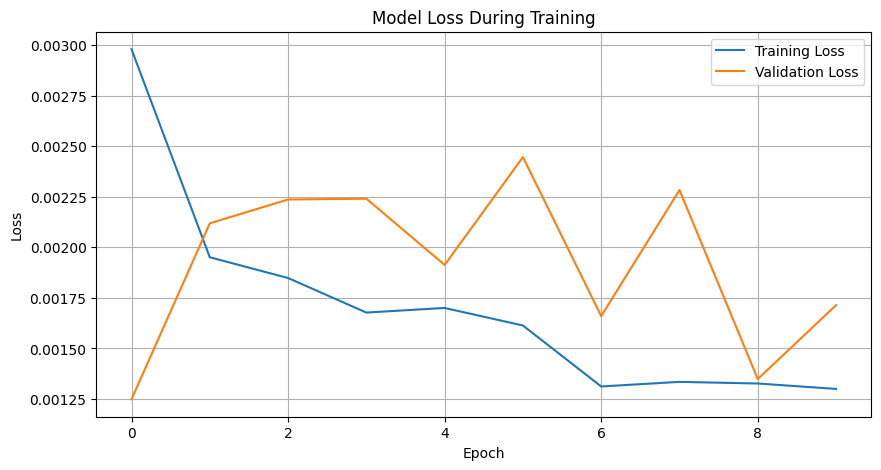

In [ ]:
# Ploting the results

plot_metrics(history)

In [ ]:
model_save_path = 'siamese_network_model.h5'

siamese_network.save(model_save_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Distance(anchor, positive): 0.6912
Distance(anchor, negative): 1.5848
Condition Met



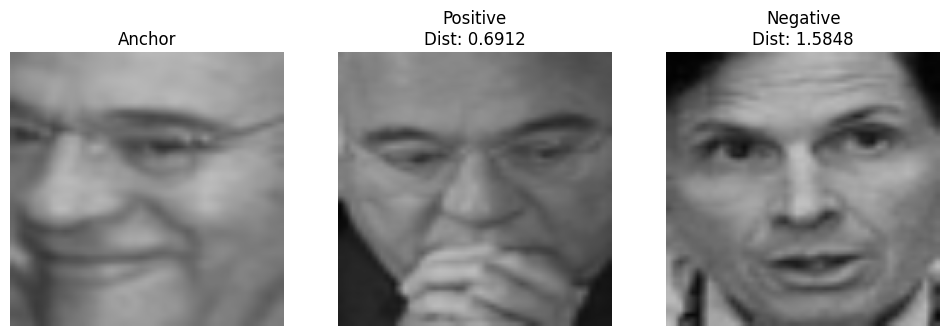



Distance(anchor, positive): 0.5610
Distance(anchor, negative): 1.4257
Condition Met



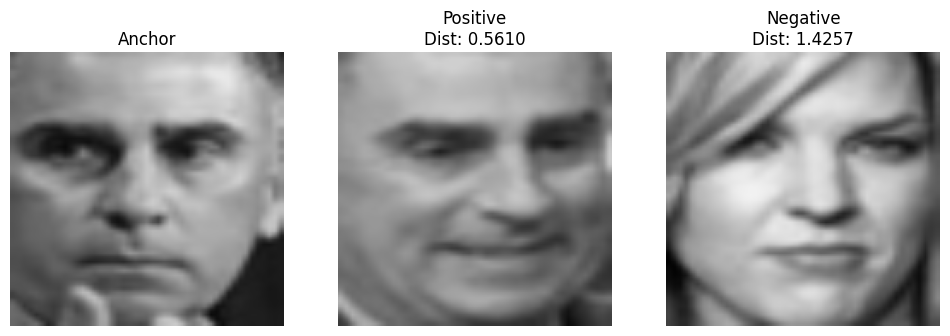



Distance(anchor, positive): 0.6017
Distance(anchor, negative): 1.6196
Condition Met



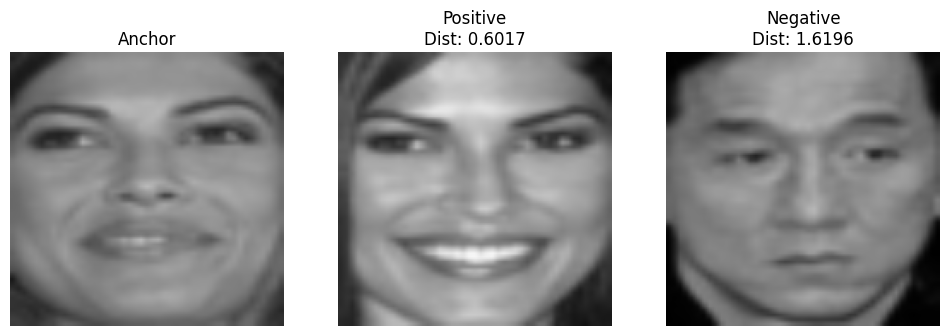



Distance(anchor, positive): 0.7032
Distance(anchor, negative): 1.1429
Condition Met



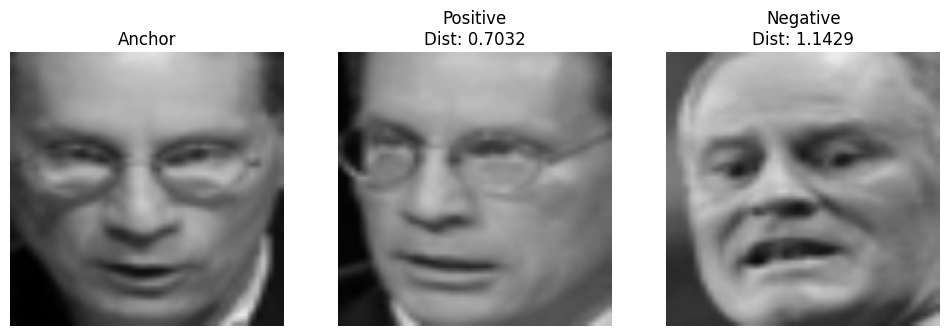



Distance(anchor, positive): 0.8696
Distance(anchor, negative): 1.4524
Condition Met



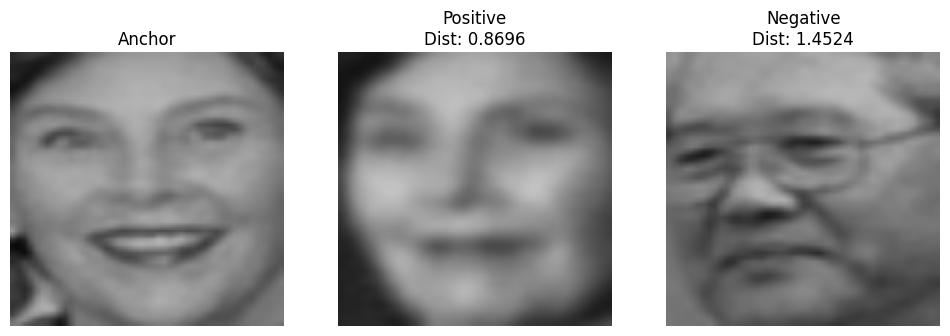



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Distance(anchor, positive): 0.6628
Distance(anchor, negative): 1.4567
Condition Met



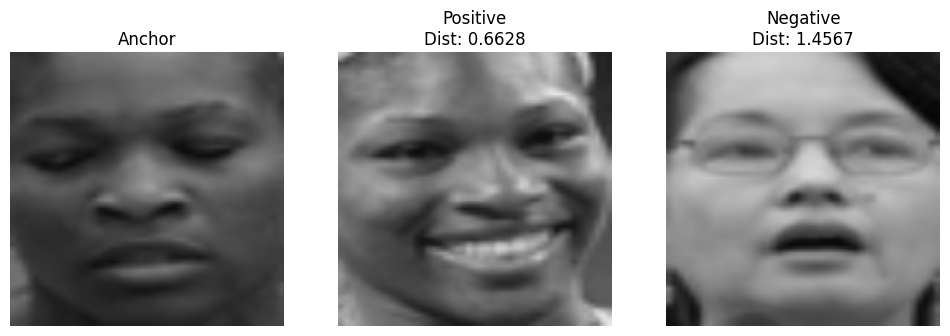



Distance(anchor, positive): 0.4251
Distance(anchor, negative): 1.3563
Condition Met



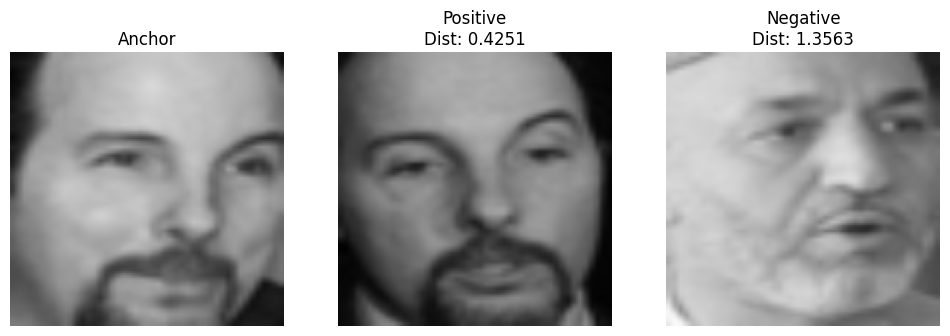



Distance(anchor, positive): 0.8272
Distance(anchor, negative): 1.3759
Condition Met



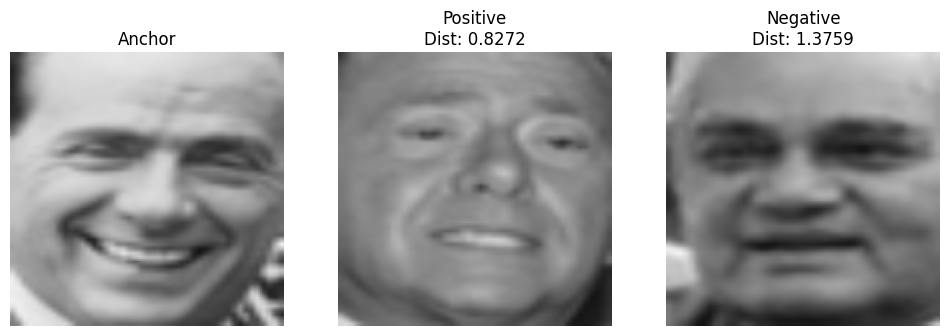



Distance(anchor, positive): 0.8636
Distance(anchor, negative): 1.3517
Condition Met



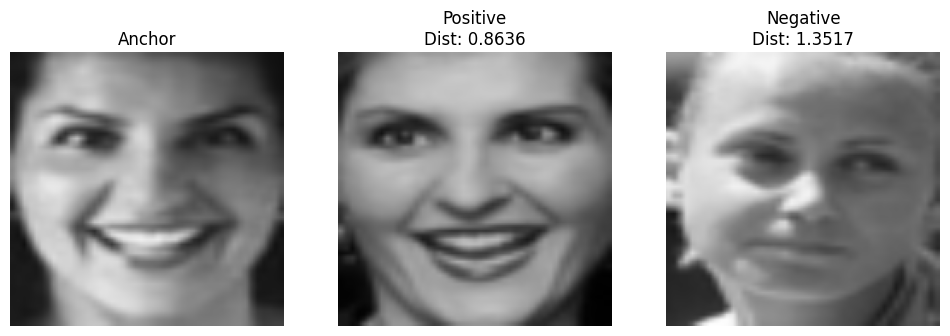



Distance(anchor, positive): 0.6798
Distance(anchor, negative): 1.4251
Condition Met



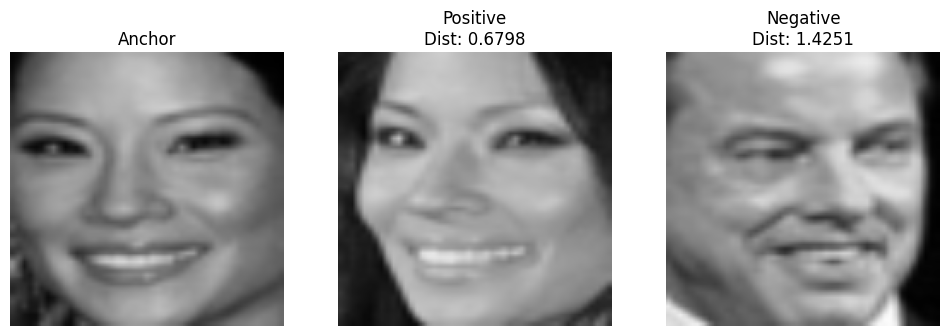



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Distance(anchor, positive): 0.5621
Distance(anchor, negative): 1.3248
Condition Met



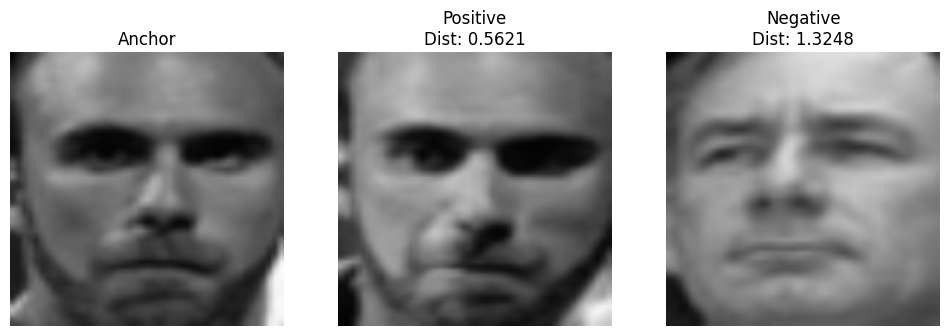



Distance(anchor, positive): 0.7336
Distance(anchor, negative): 1.4590
Condition Met



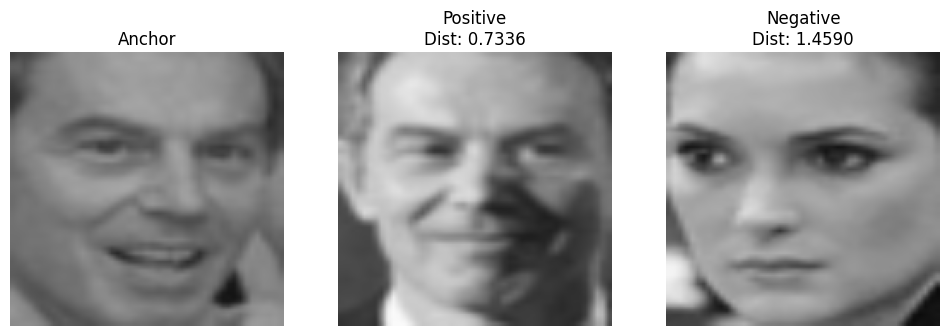



Distance(anchor, positive): 0.5368
Distance(anchor, negative): 1.2007
Condition Met



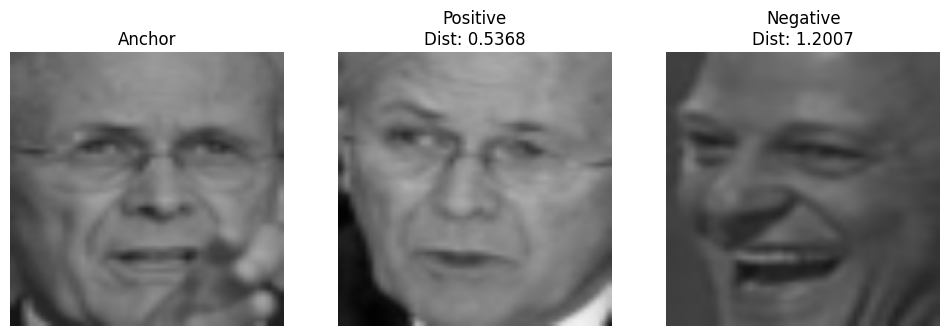



Distance(anchor, positive): 0.6337
Distance(anchor, negative): 1.5648
Condition Met



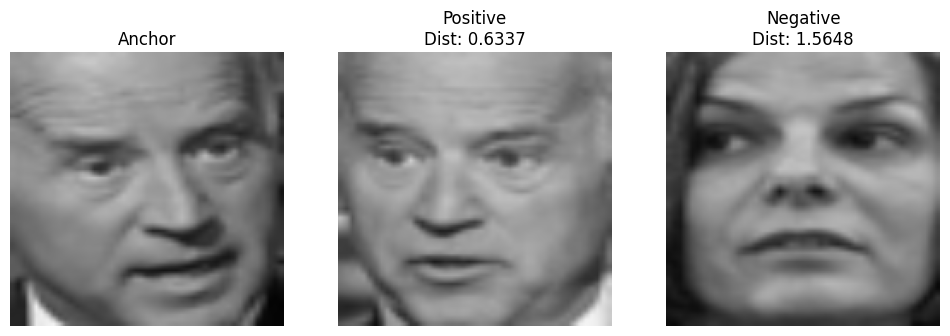



Distance(anchor, positive): 0.8172
Distance(anchor, negative): 1.3928
Condition Met



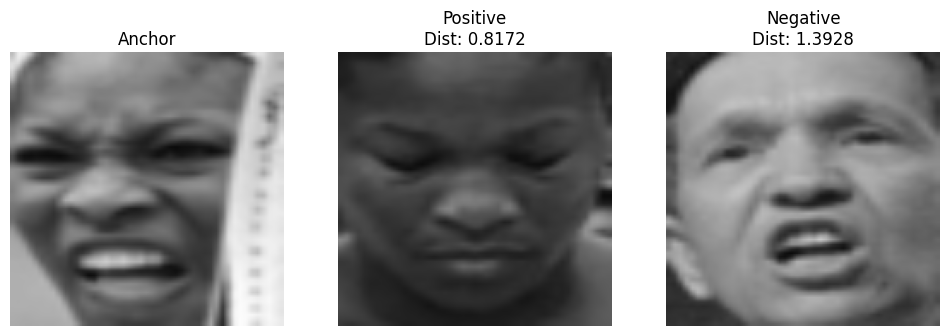



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Distance(anchor, positive): 0.5896
Distance(anchor, negative): 1.1819
Condition Met



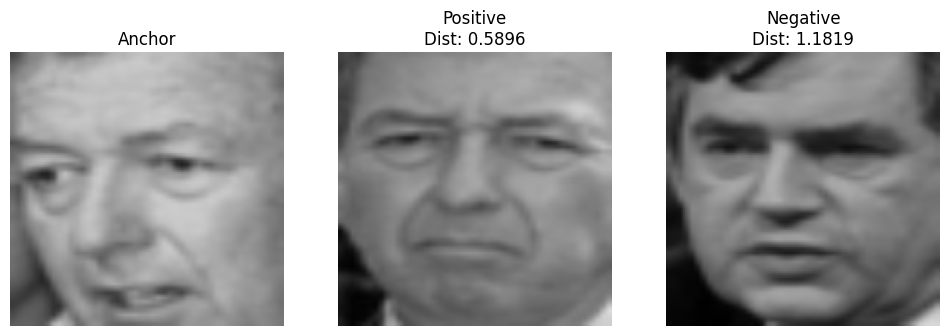



Distance(anchor, positive): 0.6874
Distance(anchor, negative): 1.5232
Condition Met



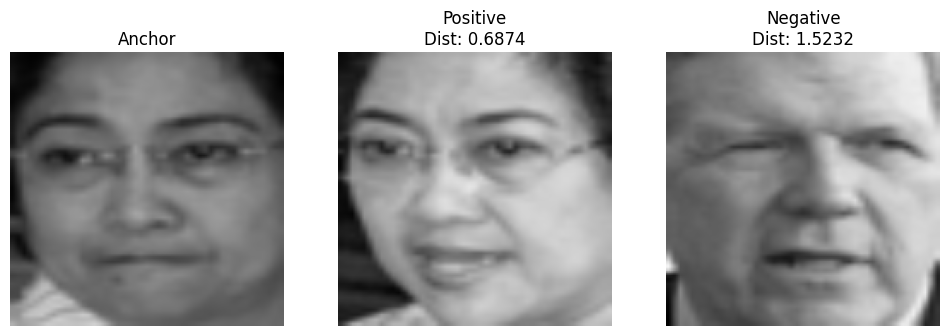



Distance(anchor, positive): 0.7905
Distance(anchor, negative): 1.4847
Condition Met



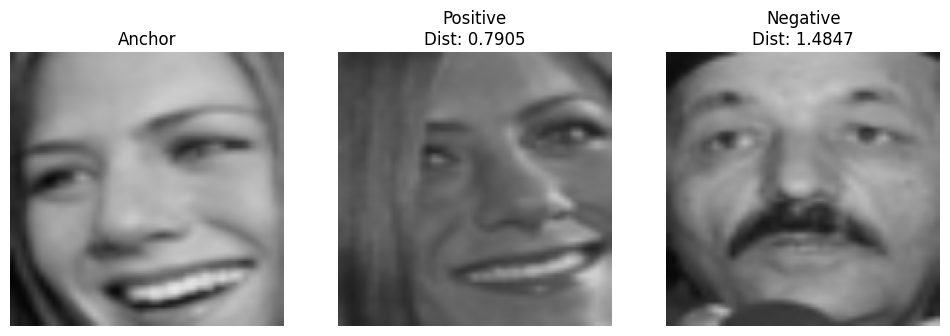



Distance(anchor, positive): 0.6419
Distance(anchor, negative): 1.3161
Condition Met



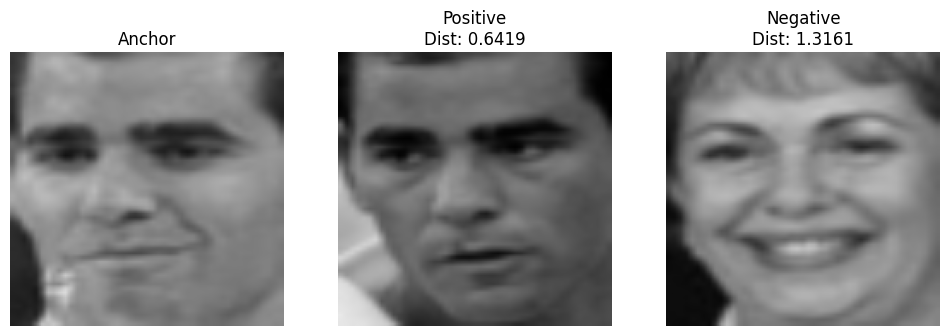



Distance(anchor, positive): 0.9435
Distance(anchor, negative): 1.3088
Condition Met



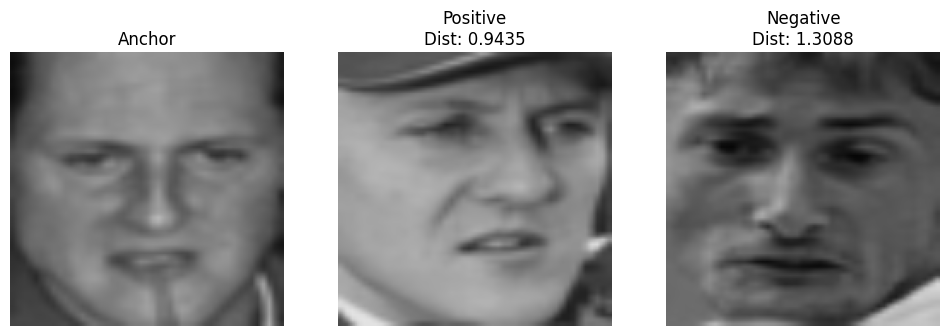



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Distance(anchor, positive): 0.5438
Distance(anchor, negative): 1.3323
Condition Met



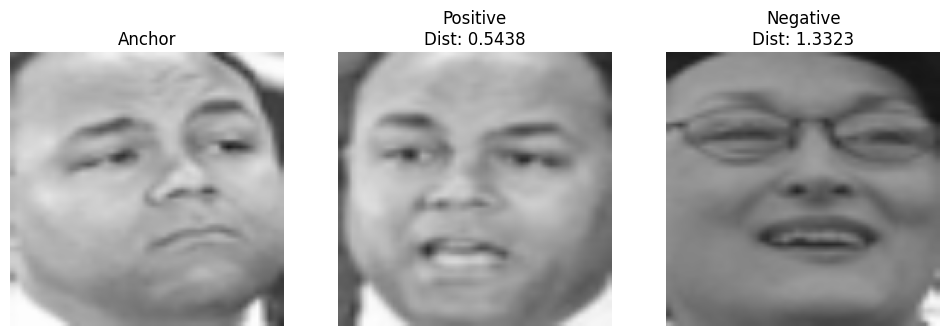



Distance(anchor, positive): 0.0000
Distance(anchor, negative): 1.5227
Condition Met



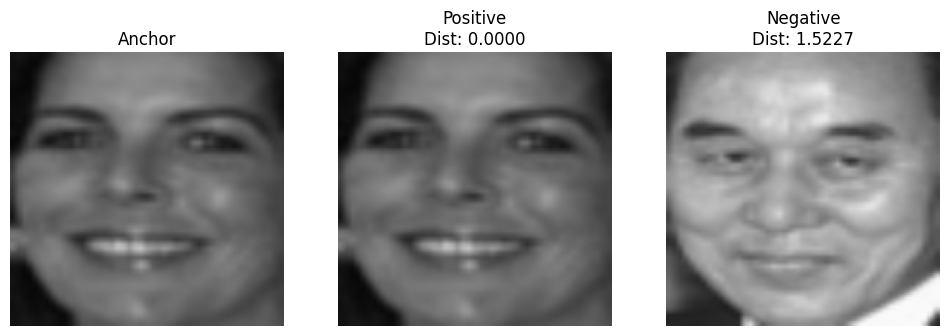



Distance(anchor, positive): 0.6650
Distance(anchor, negative): 1.1808
Condition Met



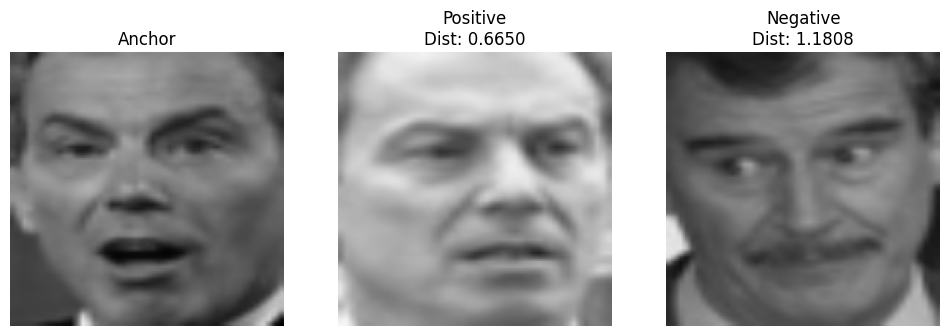



Distance(anchor, positive): 0.5336
Distance(anchor, negative): 1.3936
Condition Met



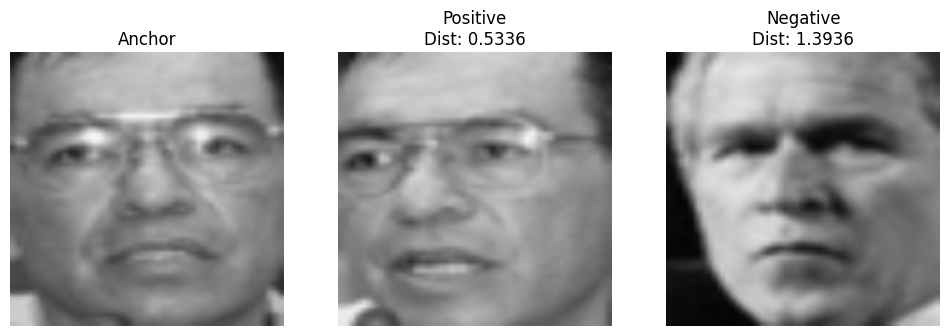



Distance(anchor, positive): 0.6082
Distance(anchor, negative): 1.2855
Condition Met



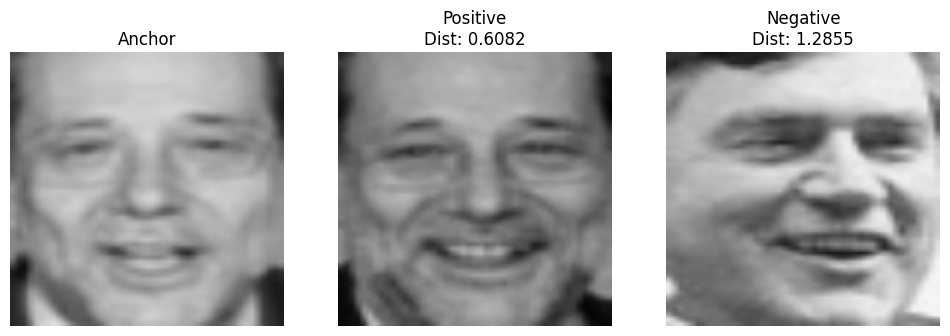

In [ ]:
import numpy as np

import matplotlib.pyplot as plt



# computing Euclidean distance

def euclidean_distance(emb1, emb2):

    return np.linalg.norm(emb1 - emb2, axis=1)



# ploting triplet images and distances

def plot_triplet(anchor, positive, negative, dist_positive, dist_negative, correct, alpha):

    """

    Plots the triplet (anchor, positive, negative) and shows the distances.

    """

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))



    # Anchor image

    axes[0].imshow(np.squeeze(anchor), cmap='gray')

    axes[0].set_title("Anchor")

    axes[0].axis("off")



    # Positive image

    axes[1].imshow(np.squeeze(positive), cmap='gray')

    axes[1].set_title(f"Positive\nDist: {dist_positive:.4f}")

    axes[1].axis("off")



    # Negative image

    axes[2].imshow(np.squeeze(negative), cmap='gray')

    axes[2].set_title(f"Negative\nDist: {dist_negative:.4f}")

    axes[2].axis("off")



    # Determining if the model correctly differentiates between positive and negative

    condition_met = "Condition Met" if correct else "Condition Not Met"



    plt.show()

    print(f"\n")



# Evaluating the model on triplet predictions

def evaluate_triplet_predictions_with_images(siamese_network, val_dataset, num_triplets=5, emb_dim=512, alpha=0.2):

    """

    Evaluating the triplet predictions and check whether the model has learned to differentiate between

    the anchor-positive and anchor-negative pairs correctly, and show the images being compared.


    """

    correct_triplets = 0



    # Looping through the validation dataset and take `num_triplets` for evaluation

    for idx, (triplet, _) in enumerate(val_dataset.take(num_triplets)):

        anchor, positive, negative = triplet



        # Predict embeddings for the entire batch (remove np.expand_dims)

        predicted_embeddings = siamese_network.predict([anchor, positive, negative])



        # Extracting embeddings

        emb_anchor = predicted_embeddings[:, :emb_dim]

        emb_positive = predicted_embeddings[:, emb_dim:2*emb_dim]

        emb_negative = predicted_embeddings[:, 2*emb_dim:]



        # Calculating distances

        dist_positive = euclidean_distance(emb_anchor, emb_positive)

        dist_negative = euclidean_distance(emb_anchor, emb_negative)



        # Checking if the model correctly distinguishes between anchor-positive and anchor-negative

        correct = dist_positive + alpha < dist_negative



        # Showing the first `num_triplets` images and distances

        if idx < num_triplets:

            print(f"\n")

            for i in range(min(5, len(correct))):  # Print the first few examples

                print(f"Distance(anchor, positive): {dist_positive[i]:.4f}")

                print(f"Distance(anchor, negative): {dist_negative[i]:.4f}")

                if dist_positive[i] < dist_negative[i]:

                    print(f"Condition Met\n")

                else:

                    print(f"Condition Not Met\n")



                # Plotting the triplet images

                plot_triplet(anchor[i], positive[i], negative[i], dist_positive[i], dist_negative[i], correct[i], alpha)



# Evaluating the model and show images

evaluate_triplet_predictions_with_images(siamese_network, val_dataset, num_triplets=5, emb_dim=emb_dim, alpha=alpha)


In [ ]:
from mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_face_size(image_path, min_face_area_ratio=0.05):
    """Detecting faces and determines if they are too small based on area ratio."""
    # Loading and converting the image to RGB
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return False

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()

    # Detecting faces
    results = detector.detect_faces(img_rgb)
    if not results:
        print("No face detected.")
        return False

    largest_face = max(results, key=lambda res: res['box'][2] * res['box'][3])
    x, y, w, h = largest_face['box']

    # Calculating the area of the face and the total image area
    face_area = w * h
    image_area = img.shape[0] * img.shape[1]
    face_area_ratio = face_area / image_area

    print(f"Face area ratio: {face_area_ratio:.4f}")

    if face_area_ratio < min_face_area_ratio:
        print("The detected face is too small to be verified.")
        return False
    else:
        print("The detected face size is sufficient for verification.")
        return True

def detect_and_extract_face_mtcnn(image_path, target_shape=(160, 160)):
    """Detecting and extracting the largest face in the image using MTCNN."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    results = detector.detect_faces(img_rgb)

    if len(results) == 0:
        print(f"No face detected in {image_path}.")
        return None

    largest_face = max(results, key=lambda res: res['box'][2] * res['box'][3])
    x, y, w, h = largest_face['box']

    x, y = max(x, 0), max(y, 0)
    face = img_rgb[y:y+h, x:x+w]

    face_resized = cv2.resize(face, target_shape) / 255.0
    return np.expand_dims(face_resized, axis=0)

def euclideanDistance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2, axis=1)

def plotAnchorPositive(anchor, positive, dist_positive):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(np.squeeze(anchor))
    axes[0].set_title("Anchor")
    axes[0].axis("off")
    axes[1].imshow(np.squeeze(positive))
    axes[1].set_title(f"Positive\nDistance: {dist_positive:.4f}")
    axes[1].axis("off")
    plt.show()

def evaluate(siamese, ref, toComapre, ghost, emb_dim=512, alpha=0.2):
    if not detect_face_size(toComapre):
        print("Face is too small for verification please move closer to the camera.")

        return

    référence = detect_and_extract_face_mtcnn(ref)
    nouveau = detect_and_extract_face_mtcnn(toComapre)
    fantôme = detect_and_extract_face_mtcnn(ghost)

    if référence is None or nouveau is None or fantôme is None:
        print("One or more images failed to process.")
        return

    predictedEmbeddings = siamese.predict([référence, nouveau, fantôme], verbose=0)

    embréférence = predictedEmbeddings[:, :emb_dim]
    embnouveau = predictedEmbeddings[:, emb_dim:2*emb_dim]

    dist = euclideanDistance(embréférence, embnouveau)
    plotAnchorPositive(référence[0], nouveau[0], dist[0])

    print(f"Distance between the reference and presented image: {dist[0]:.4f}")
    if dist[0] >= 1.0:
        print("Different Individuals - Access denied.")
    else:
        print("Same Person - Access granted!!")

def oneShotVerification(ref, nEw):
    thirdGhostImage = "/kaggle/input/newdataset/e1.jpg"
    evaluate(siamese_network, ref, nEw, thirdGhostImage, emb_dim=512, alpha=0.2)

Face area ratio: 0.1343
The detected face size is sufficient for verification.


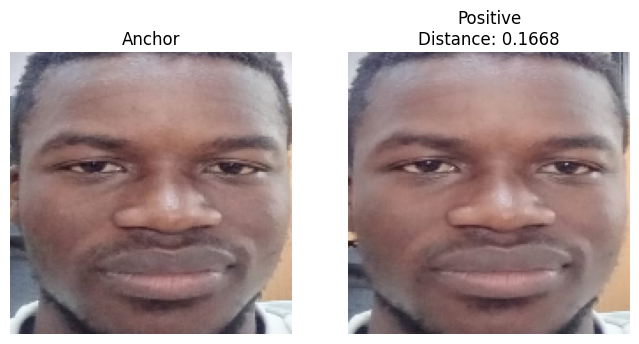

Distance between the reference and presented image: 0.1668
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/clearrefernce/fe1.jpg"

oneShotVerification(accountOf , imageToVerifify)

Face area ratio: 0.3131
The detected face size is sufficient for verification.


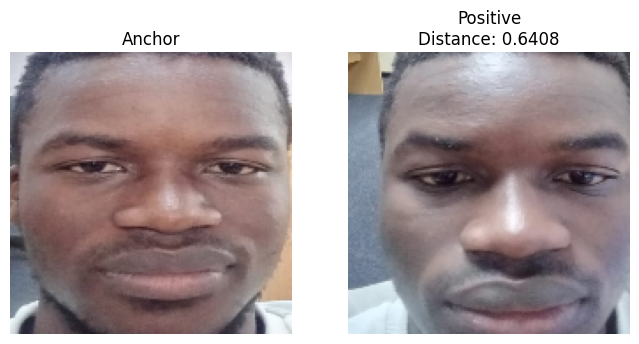

Distance between the reference and presented image: 0.6408
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/etienne/IMG-20241017-WA0006.jpg"

oneShotVerification(accountOf , imageToVerifify)

Face area ratio: 0.1517
The detected face size is sufficient for verification.


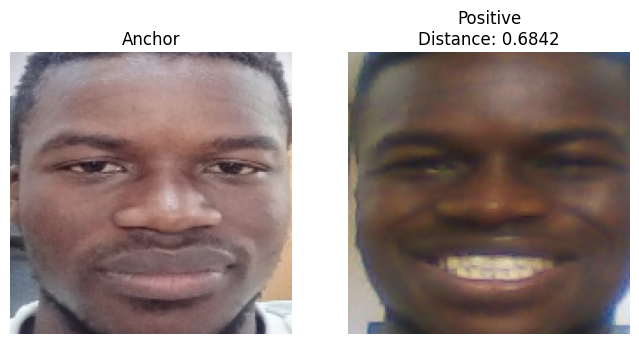

Distance between the reference and presented image: 0.6842
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1793
The detected face size is sufficient for verification.


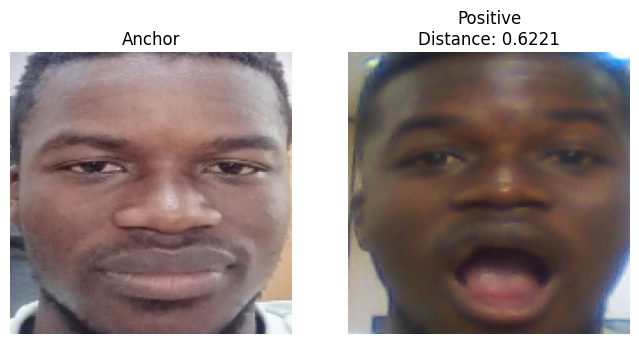

Distance between the reference and presented image: 0.6221
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1517
The detected face size is sufficient for verification.


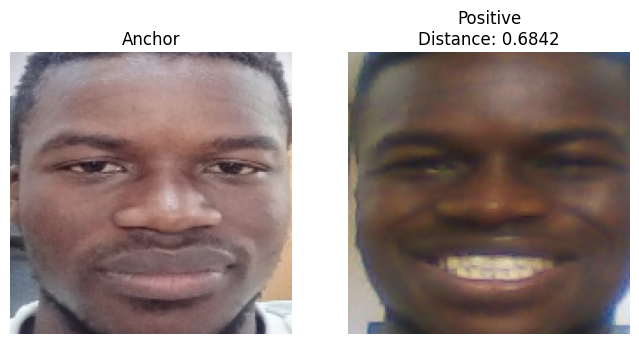

Distance between the reference and presented image: 0.6842
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/clearrefernce/f2.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1517
The detected face size is sufficient for verification.


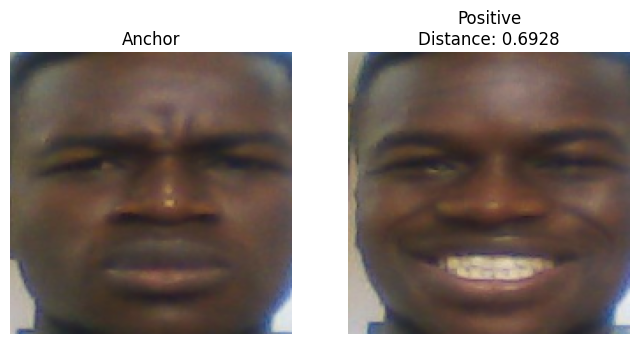

Distance between the reference and presented image: 0.6928
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/newdataset/e5.jpg"

imageToVerifify = "/kaggle/input/newdataset/e2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1793
The detected face size is sufficient for verification.


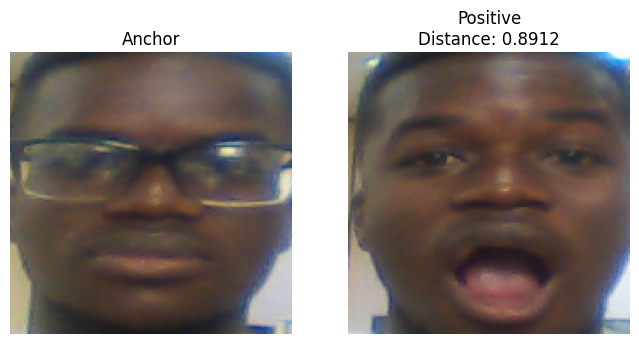

Distance between the reference and presented image: 0.8912
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/newdataset/e1.jpg"

imageToVerifify = "/kaggle/input/newdataset/e4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.3131
The detected face size is sufficient for verification.


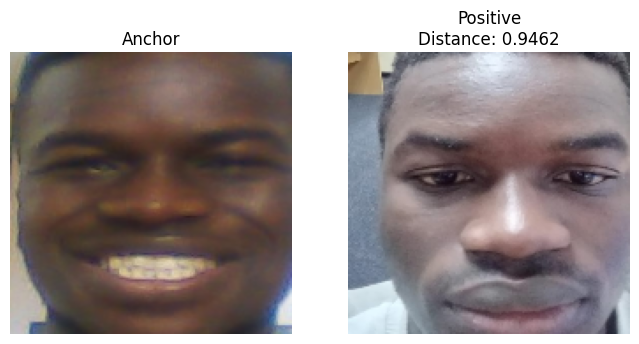

Distance between the reference and presented image: 0.9462
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/newdataset/e2.jpg"

imageToVerifify = "/kaggle/input/etienne/IMG-20241017-WA0006.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1473
The detected face size is sufficient for verification.


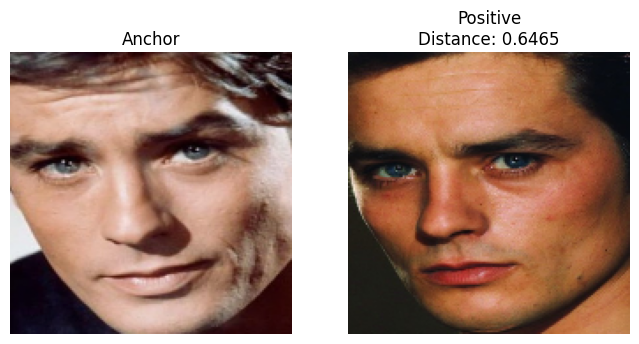

Distance between the reference and presented image: 0.6465
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/delon_3.webp"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2087
The detected face size is sufficient for verification.


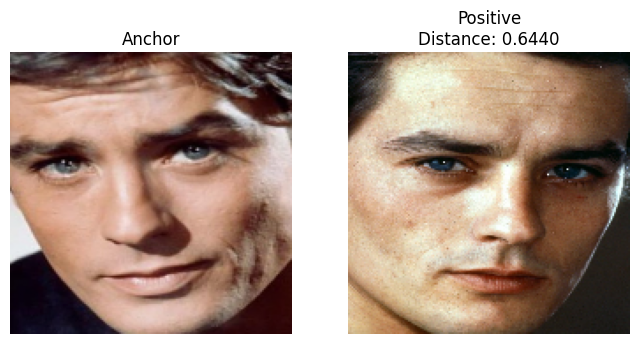

Distance between the reference and presented image: 0.6440
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/delon_3.webp"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_4.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1473
The detected face size is sufficient for verification.


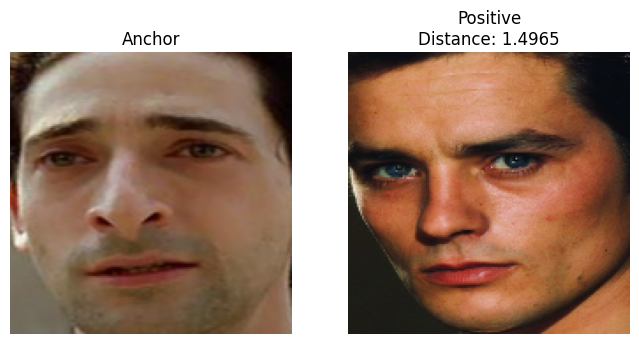

Distance between the reference and presented image: 1.4965
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2215
The detected face size is sufficient for verification.


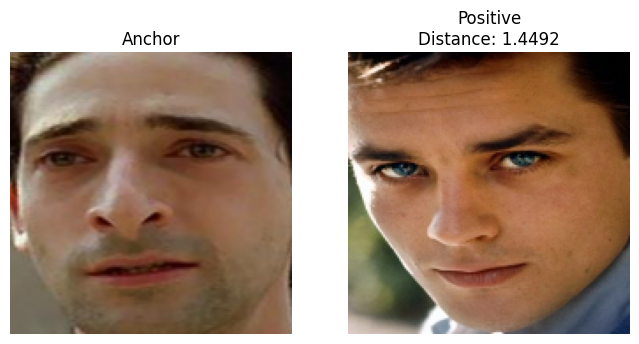

Distance between the reference and presented image: 1.4492
Different Individuals - Access denied.


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/delon_1.webp"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1108
The detected face size is sufficient for verification.


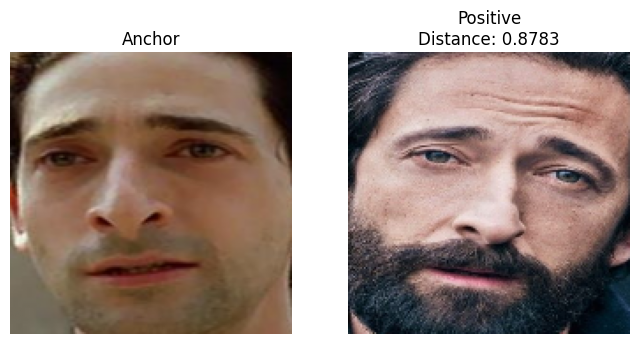

Distance between the reference and presented image: 0.8783
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_3.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1792
The detected face size is sufficient for verification.


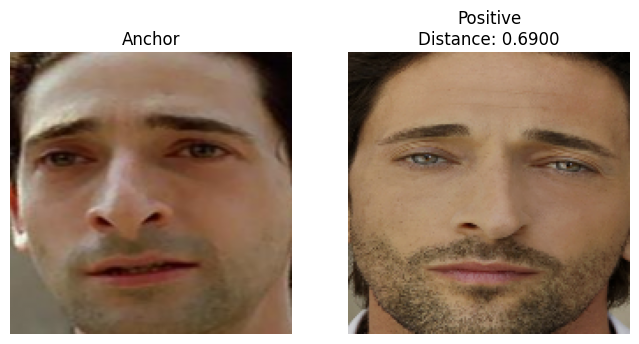

Distance between the reference and presented image: 0.6900
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_2.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2300
The detected face size is sufficient for verification.


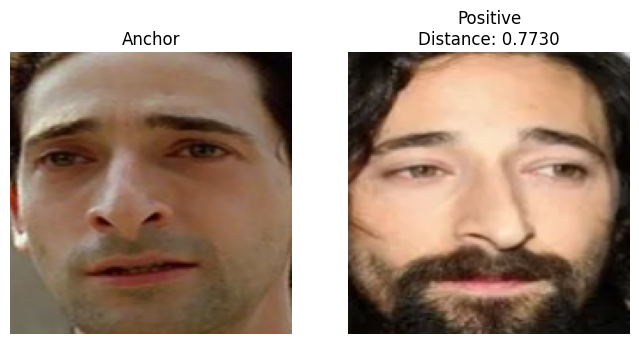

Distance between the reference and presented image: 0.7730
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien_brody_1.webp"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.1290
The detected face size is sufficient for verification.


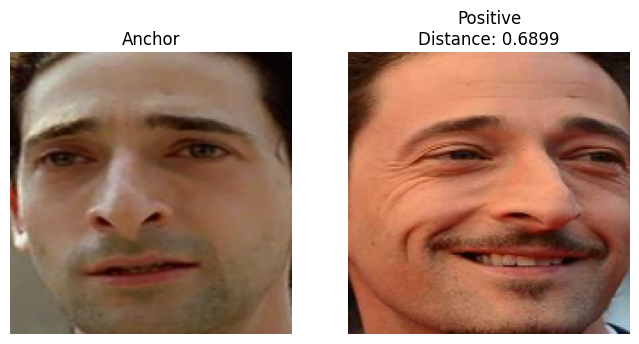

Distance between the reference and presented image: 0.6899
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien-brody_6.jpg"

oneShotVerification(accountOf , imageToVerifify )

Face area ratio: 0.2459
The detected face size is sufficient for verification.


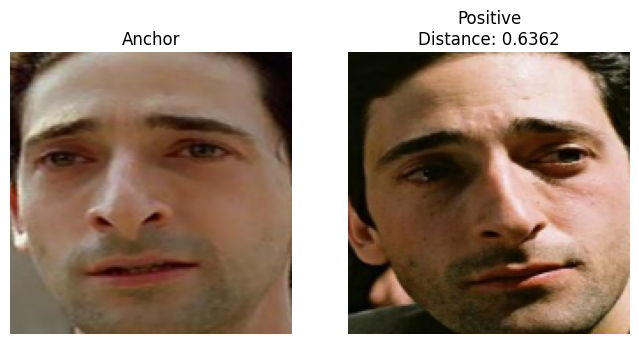

Distance between the reference and presented image: 0.6362
Same Person - Access granted!!


In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/finaldatasetforthis/adrien-brody_5.jpg"

oneShotVerification(accountOf , imageToVerifify )

# Faces that are too far from the camera

In [ ]:
# function to display the images that have their faces too far to be verified, simulating what would happen if this model was to be implemented at an ATM
def plot_images(path):

    img = cv2.imread(path)

    if img is None:
        print("One or both images could not be loaded.")
        return

    # Converting from BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Plotting the images
    fig, axes = plt.subplots(1,figsize=(10, 5))
    axes.imshow(img_rgb)
    axes.set_title("Image to Verify")
    axes.axis("off")

Face area ratio: 0.0053
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.


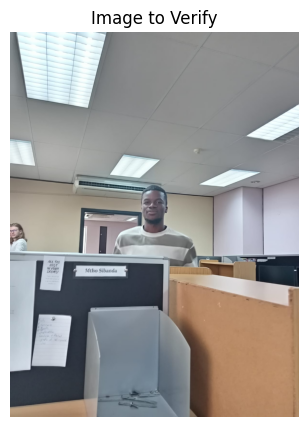

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f1.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

Face area ratio: 0.0150
The detected face is too small to be verified.
Face is too small for verification please move closer to the camera.


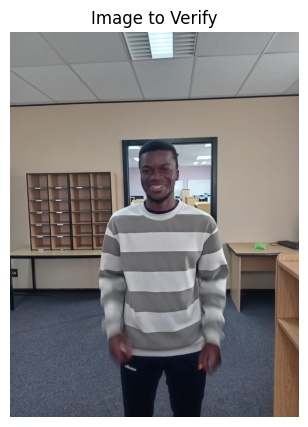

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f2.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f3.jpg"

oneShotVerification(accountOf , imageToVerifify )

plot_images(imageToVerifify)

In [ ]:
accountOf = "/kaggle/input/finaldatasetforthis/adrien-brody_1.jpg"

imageToVerifify = "/kaggle/input/farfaces/f4.jpg"

oneShotVerification(accountOf , imageToVerifify )